# 4. Clustering and Recommender system

In this notebook I cluster the courses and based on the new clusters and other course features, I build a recommender system.

For the clustering I investigated the attributes OBJECTIVES and DESCRIPTION. After the preparation of these two attributes, the first part of the notebook tries to cluster the courses based on the attribute OBJECTIVES, while in the second part I build the clusters by means of the course DESCRIPTIONs. After comparing the results, I used the the clustering algorithm based on the description field. The last part of the notebook shows the recommender system,  that helps the user to find similar courses to the previously taken ones.

In [1]:
import udemy_functions # all functions to build the clusters and the recomender systems

import pandas as pd
import numpy as np
import ast
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import pickle

c:\Users\Nada\anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nada\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pandas as pd

# Test pandas functionality
df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
print(df)

   A  B
0  1  4
1  2  5
2  3  6


## 4.1. Prepare the data

In [2]:
df_courses=pd.read_csv('data/cleaned/df_courses.csv', index_col=0, sep=' ', converters={"objectives": ast.literal_eval})
df_courses.head()

,avg_rating,avg_rating_recent,description_text,has_certificate,is_paid,id,instructional_level,is_enrollable_on_mobile,is_owned_by_instructor_team,is_practice_test_course,...,published_title,relevancy_score,rating_1,rating_2,rating_3,rating_4,rating_5,published_since_month,primary_category,primary_subcategory
0,4.571429,4.594609,IMPORTANT NOTE: The material of this course is...,False,False,473160,All Levels,True,False,False,...,web-design-secrets,NaN,0.014,0.020,0.104,0.318,0.545,2015-04-13 18:29:47+00:00,Development,Web Development
1,4.496454,4.483711,Do you want to become a programmer? O...,False,False,433798,Beginner Level,True,False,False,...,pythonforbeginnersintro,NaN,0.012,0.020,0.133,0.380,0.455,2015-03-02 01:23:00+00:00,Development,Programming Languages
2,4.550599,4.560926,Learn to program in the Java progra...,False,False,24823,All Levels,True,False,False,...,java-tutorial,NaN,0.015,0.025,0.135,0.363,0.463,2012-09-30 20:11:57+00:00,Development,Programming Languages
3,4.547253,4.568732,"This course teaches you the powerful, f...",False,False,247190,Beginner Level,True,False,False,...,free-learn-c-tutorial-beginners,NaN,0.016,0.023,0.129,0.350,0.481,2014-10-11 21:33:45+00:00,Development,Programming Languages
4,4.540984,4.599431,"Welcome! This is Deep Learning, Machine Learni...",False,False,3060786,All Levels,True,False,False,...,numpy-python,NaN,0.008,0.009,0.074,0.276,0.632,2020-05-06 21:10:30+00:00,Development,Data Science


In [3]:
df_reviews=pd.read_csv('data/cleaned/df_reviews.csv', index_col=0)
df_reviews.head()

,course_id,created,rating,user_name
0,473160,2021-12-25T21:39:13-08:00,5.0,Rastko Sasic
1,473160,2021-12-25T18:38:18-08:00,5.0,Mad
2,473160,2021-12-25T08:30:57-08:00,3.5,Anar Mamedovi
3,473160,2021-12-25T03:06:18-08:00,4.0,Tarwat Uddin
4,473160,2021-12-25T01:34:47-08:00,5.0,Aakash Bhalla


### 4.1.1 Pepare the attribute OBJECTIVES

The feature Objectives is a list of course objectives. At first I make a string from the list items by means of the function combine_list. 

For the stemming I saved all words with their stemmed correspondence in the dataframe vocab_frame. Since I am interested only in the stemmed words, I dropped all the duplicates from this dataframe (e.g. I treat learn and learning as the same words). This dataframe will be used to transform back the stemmed words. 

I defined the StopWords which contains all the expression that shouldn't be considered from the texts. 

Finally I applied the TfidfVectorizer on the objectives attribute: This transformator builds feature vectors from text documents so, that it helps to identify words which are frequent in the text but rare in the corpus.

In [4]:
objectives_text=df_courses['objectives'].apply(udemy_functions.combine_list)

In [5]:
vocab_frame_orig=udemy_functions.vocab_stem(objectives_text)
#drop duplicates from the dataframe with stemmed words
vocab_frame=udemy_functions.drop_words(vocab_frame_orig)

In [6]:
StopWords=set(stopwords.words('english')+list(punctuation)+["’", "n't", "'s", "--", "-", "...", "``", "''", "“", "039"])

In [7]:
#use TfidfVectorizer 
vectorizer= TfidfVectorizer(stop_words=StopWords, tokenizer=udemy_functions.tokenize, max_features=1000, max_df=0.8)
X=vectorizer.fit_transform(objectives_text)
X.shape

(8102, 1000)

In [8]:
word_features = vectorizer.get_feature_names()
word_features[50:55]

['analyz', 'android', 'angular', 'angularj', 'ani']

### 4.1.2 Prepare the attribute DESCRIPTION

I executed the same steps as by the attribute Objectives except the combine_list functions: the attribute Description is alredy a string and not a list.

In [9]:
vocab_frame_descr=udemy_functions.vocab_stem(df_courses['description_text'])
vocab_frame_descr=udemy_functions.drop_words(vocab_frame_descr)

In [10]:
StopWords=set(stopwords.words('english')+list(punctuation)+["’", "n't", "'s", "--", "-", "...", "``", "''", "“", "039"])


In [11]:
#use TfidfVectorizer
vectorizer_descr= TfidfVectorizer(stop_words=StopWords, tokenizer=udemy_functions.tokenize, max_features=1000, max_df=0.8)
X_descr=vectorizer_descr.fit_transform(df_courses['description_text'])
X_descr.shape

(8102, 1000)

In [12]:
word_features_descr = vectorizer_descr.get_feature_names()
word_features_descr[50:55]

['also', 'alway', 'amaz', 'amazon', 'among']

## 4.2. Clustering with the OBJECTIVES

### 4.2.1. K-Means Clustering - with k=15 clusters

At first I tried to create 15 clusters - there are 16 subcategories, but no need for category 'others'.

In [13]:
kmeans = KMeans(n_clusters = 15, n_init = 10, random_state=1234)
kmeans.fit(X)

KMeans(n_clusters=15, random_state=1234)

In [14]:
common_words=udemy_functions.get_common_words(kmeans, 10)
udemy_functions.print_common_words(common_words, word_features, vocab_frame)

0 : java, program, learn, understand, basics, application, object, code, concepts, use
1 : website, wordpress, create, learn, themes, use, blog, build, hosting, page
2 : use, understand, create, code, learn, work, able, basics, design, course
3 : app, android, ios, build, development, create, learn, use, flutter, mobile
4 : game, unity, create, learn, development, 2d, make, c, use, 3d
5 : data, r, learn, use, science, analysis, visual, python, pandas, structure
6 : testing, automation, selenium, use, frameworks, software, api, units, understand, learn
7 : python, program, learn, use, basics, understand, data, create, functions, code
8 : javascript, learn, use, understand, create, code, basics, web, functions, elements
9 : learn, machine, use, network, neural, model, deep, build, create, understand
10 : react, js, component, app, hooks, redux, use, learn, native, build
11 : html, css, web, website, create, javascript, learn, page, use, basics
12 : sql, database, queries, data, tables, m

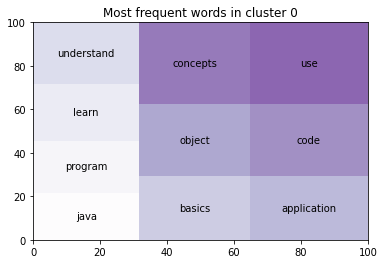

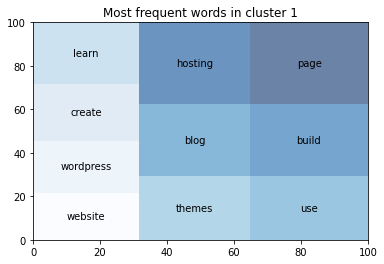

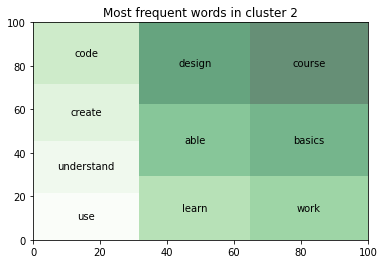

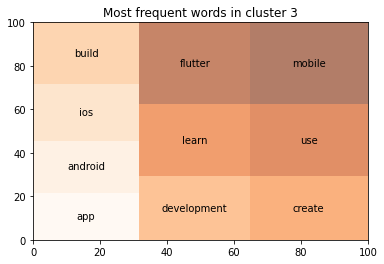

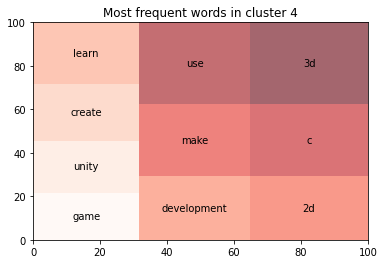

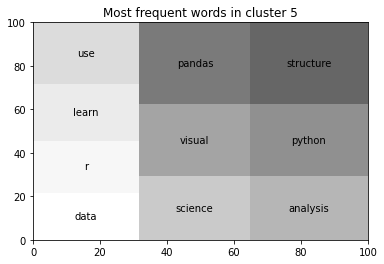

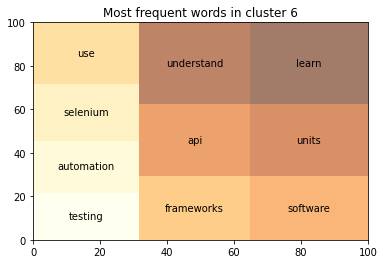

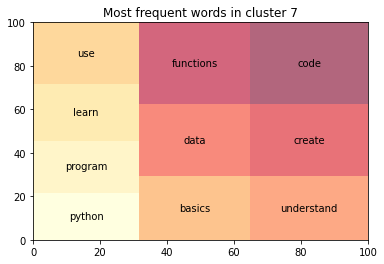

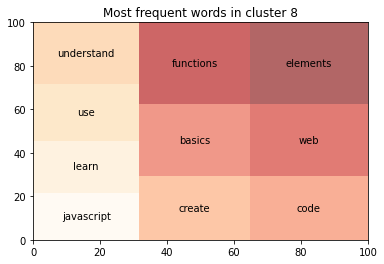

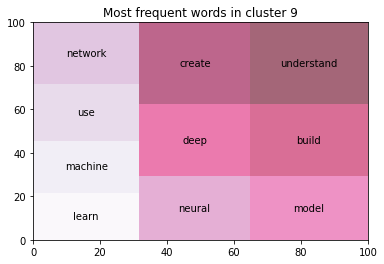

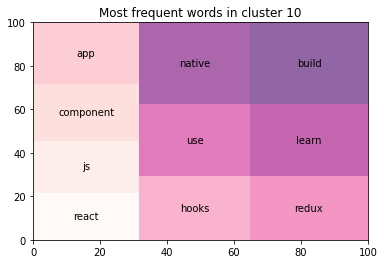

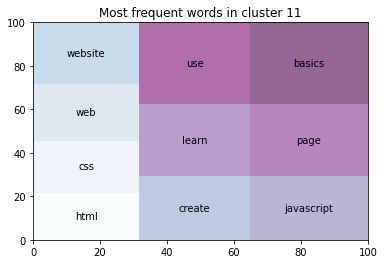

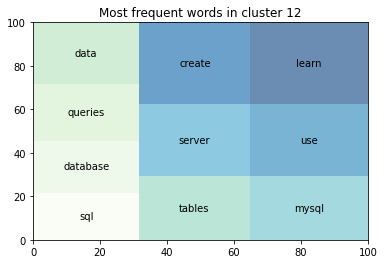

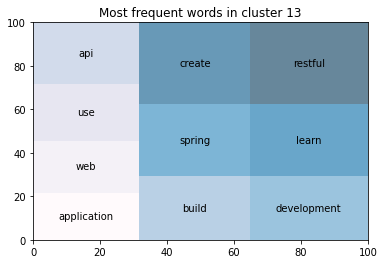

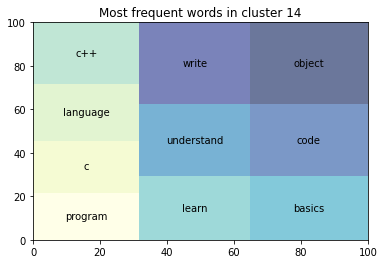

In [15]:
#plot the top10 most frequent words in each cluster
udemy_functions.squarify_words(common_words, word_features, vocab_frame)

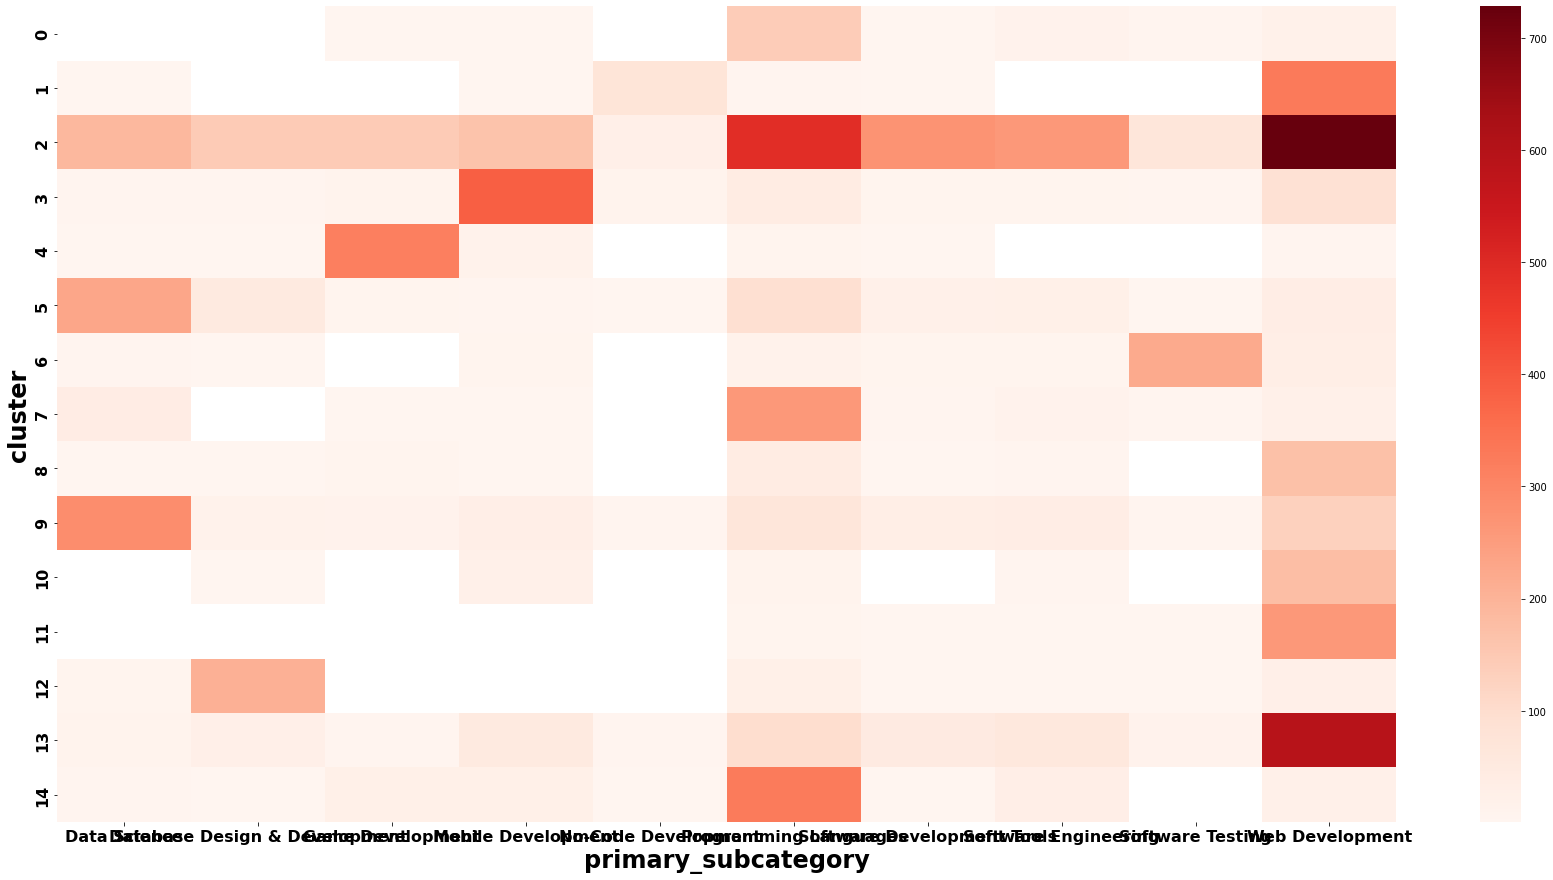

In [16]:
#heatmap of the new clusters with the subcategories
df_courses['cluster']=kmeans.labels_
udemy_functions.heatmap_categories_cluster('cluster', df_courses, 'Reds' )

### 4.2.2. Relationship between number of clusters (k) and inertia

I investigated the relationship between the number of clusters and the inertia (within-cluster sum-of-squares ) to find to optimal number of clusters. According to the elbow method, the line is an arm and the "elbow" on the arm is the value of k that is the best. 

In [17]:
kRange = range(1,30)
inertia_Kmean = udemy_functions.get_inertia(X, kRange)

Text(6, 7700, "Let's try k=6")

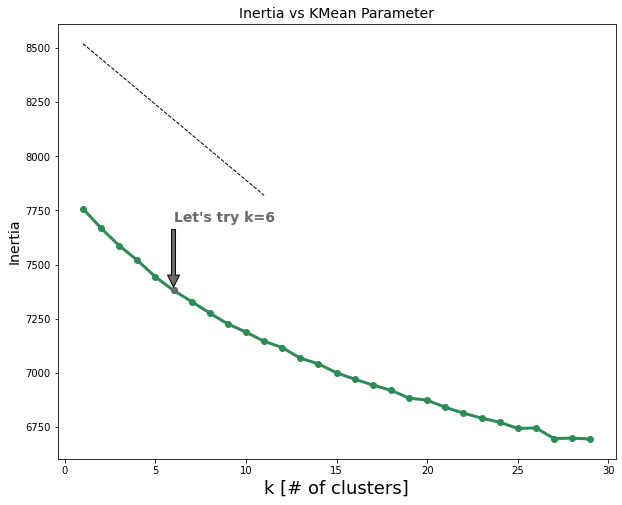

In [18]:
udemy_functions.plot_inertia(kRange, inertia_Kmean)
plt.plot([6], [inertia_Kmean[5]], 'o--', color='dimgray', linewidth=3)
plt.plot([1,6,11], [8520, 8170,7820], '--', color='k', linewidth=1)
plt.annotate("Let's try k=6", xy=(6, inertia_Kmean[5]), xytext=(6,7700),
             size=14, weight='bold', color='dimgray',
             arrowprops=dict(facecolor='dimgray', shrink=0.05))

### 4.2.3. K-Means with k=6 clusters

It is hard to tell what is the optimal number of clusters from the graph. I tried several number of clusters and finally created 6 clusters with k-Means algorithm

In [19]:
kmeans = KMeans(n_clusters = 6, n_init = 10, random_state=1234)
kmeans.fit(X)

KMeans(n_clusters=6, random_state=1234)

In [20]:
common_words=udemy_functions.get_common_words(kmeans, 10)
udemy_functions.print_common_words(common_words, word_features, vocab_frame)

0 : game, unity, create, development, learn, c, make, 2d, use, 3d
1 : website, wordpress, html, css, create, web, learn, page, use, build
2 : use, understand, data, create, application, program, testing, code, learn, basics
3 : app, android, react, build, development, ios, create, use, learn, web
4 : learn, machine, use, data, model, network, neural, create, build, program
5 : python, program, learn, use, data, basics, understand, create, code, functions


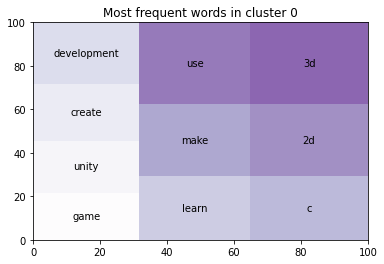

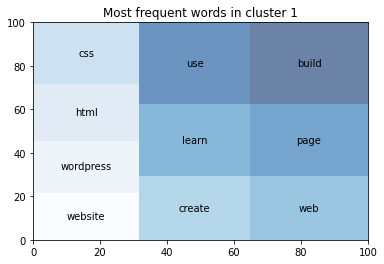

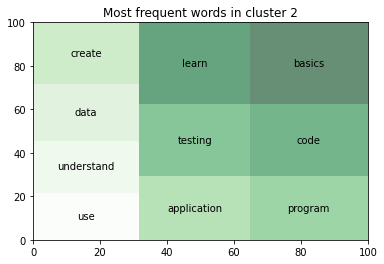

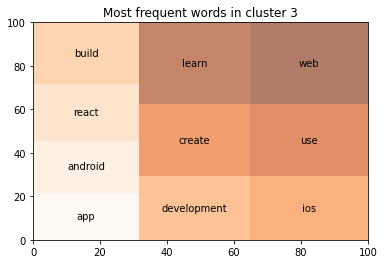

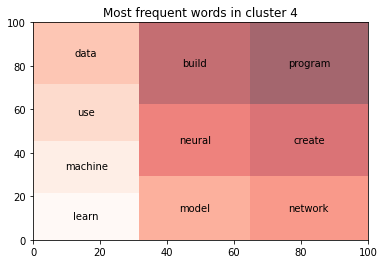

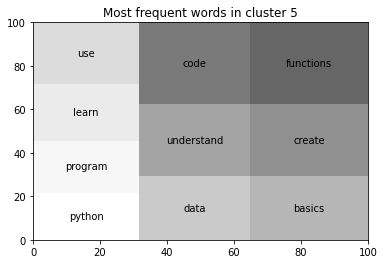

In [21]:
udemy_functions.squarify_words(common_words, word_features, vocab_frame)

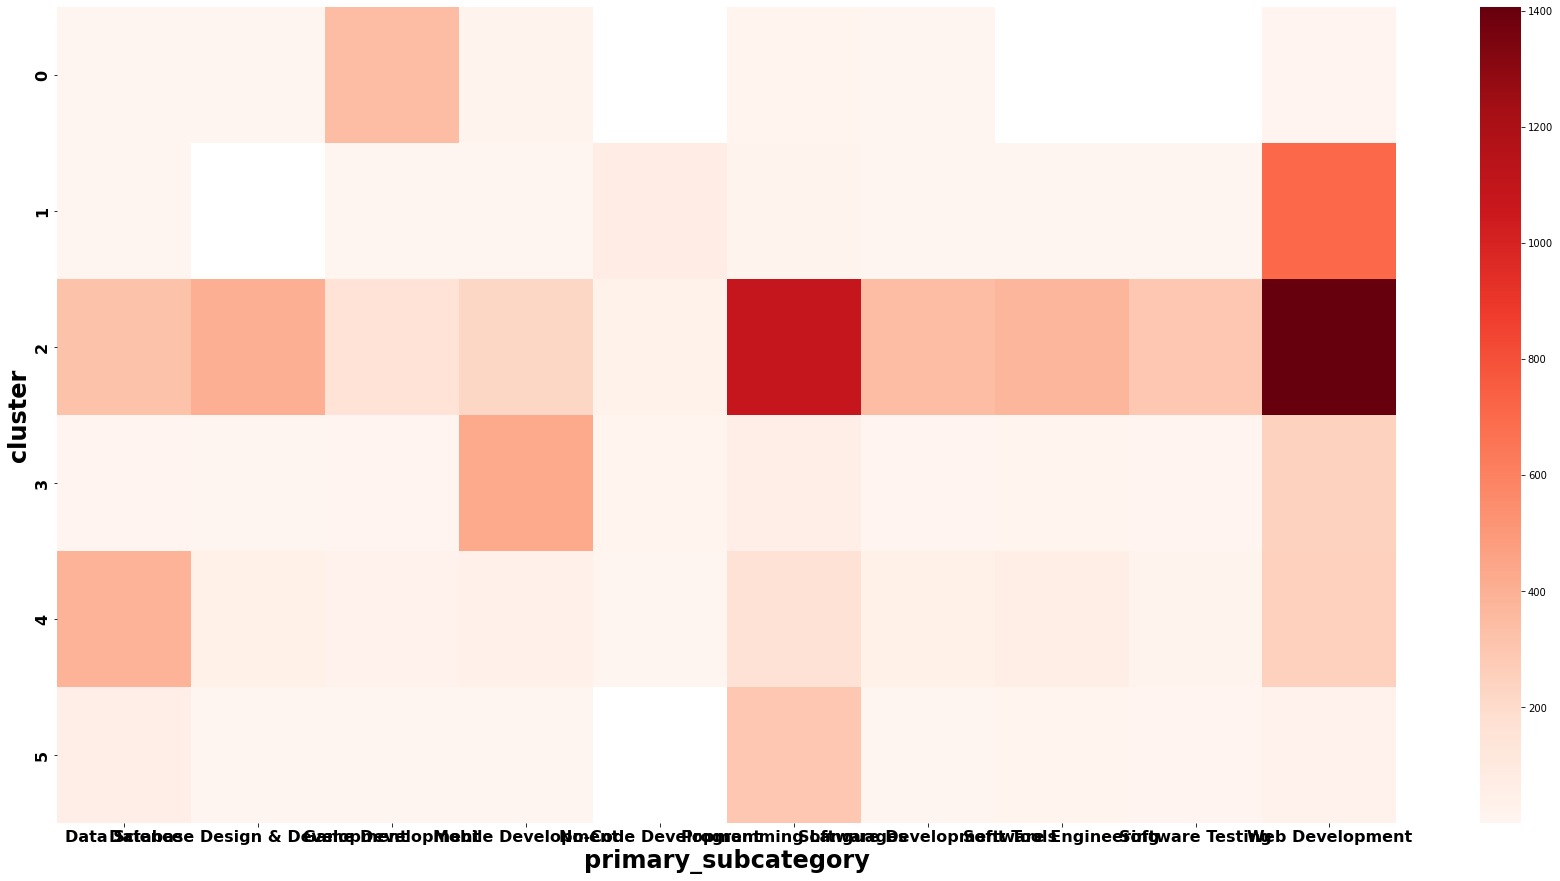

In [22]:
df_courses['cluster']=kmeans.labels_
udemy_functions.heatmap_categories_cluster('cluster', df_courses, 'Reds')

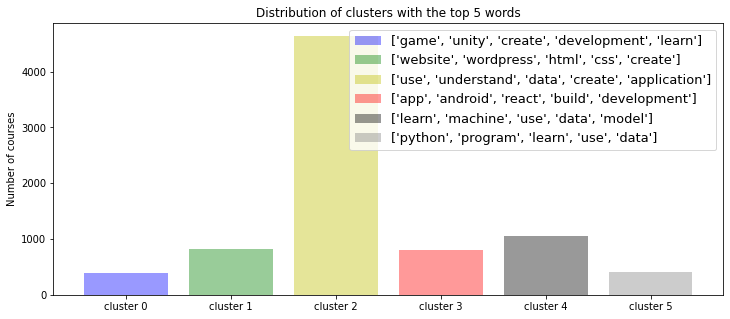

In [23]:
#plot the cluster distribution with the top5 words.More than half of the courses in the last cluster.
udemy_functions.plot_common_words(kmeans, 5, word_features, vocab_frame, df_courses, 'cluster')

In [24]:
#print out course titles in each cluster
udemy_functions.print_titles_cluster(5, df_courses, 'cluster')

['web-design-secrets' 'code-dynamic-websites'
 'web-development-learn-by-doing-html5-css3-from-scratch-introductory'
 'how-to-build-and-make-a-wordpress-website-from-scratch-2017'
 'build-your-first-website-in-1-week']
['pythonforbeginnersintro' 'test-the-pyla-waters'
 'python-from-beginner-to-expert-starter-free'
 'natural-language-processing-with-bert' 'python-introduction']
['java-tutorial' 'react-tutorial'
 'net-devops-cisco-python-automation-netconf-sdn-docker'
 'linear-regression-with-artificial-neural-network' 'node-js-api-tutorial']
['free-learn-c-tutorial-beginners' 'numpy-python' 'javascript-essentials'
 'git-and-github-crash-course-creating-a-repository-from-scratch'
 'build-a-quiz-app-with-html-css-and-javascript']
['learn-android-application-development-y'
 'become-an-android-developer-from-scratch'
 'learn-flutter-beginners-course' 'the-complete-ios-10-developer-course'
 'create-a-tiny-web-app-with-vue-3']
['code-your-first-game' 'learnecs' 'ue5-steam'
 'introduction-to-g

### 4.2.3. Hierarchical Clustering

In this section I used hierarchical clustering. This method suppose that at the beginning the items have their own clusters.
The algorithm starts to merge the individual clusters on by one. 
I created a dendrogram, which shows the distances between the clusters. I plotted the last 16 merges of the hierarchical clustering algorithm.


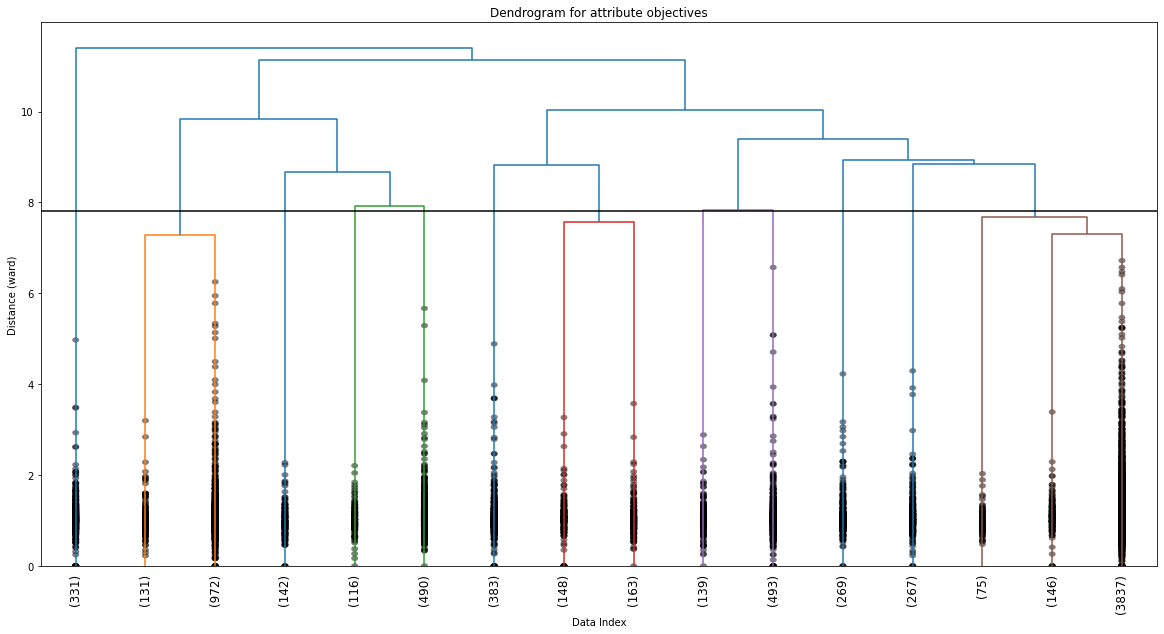

In [25]:
z=udemy_functions.get_linkage(X )
udemy_functions.plot_dendrogram(z, 16, line_dist=7.8)
#let's cut the dendrogrm at 7.8

In [26]:
#according to the dendrogram, I would cut the graph at 7.8 and get 8 clusters with the following distirbution.
df_courses['cluster_hier']=fcluster(Z=z, t=7.8, criterion='distance')
df_courses['cluster_hier'].value_counts()

12    4058
2     1103
9      493
5      490
6      383
1      331
7      311
10     269
11     267
3      142
8      139
4      116
Name: cluster_hier, dtype: int64

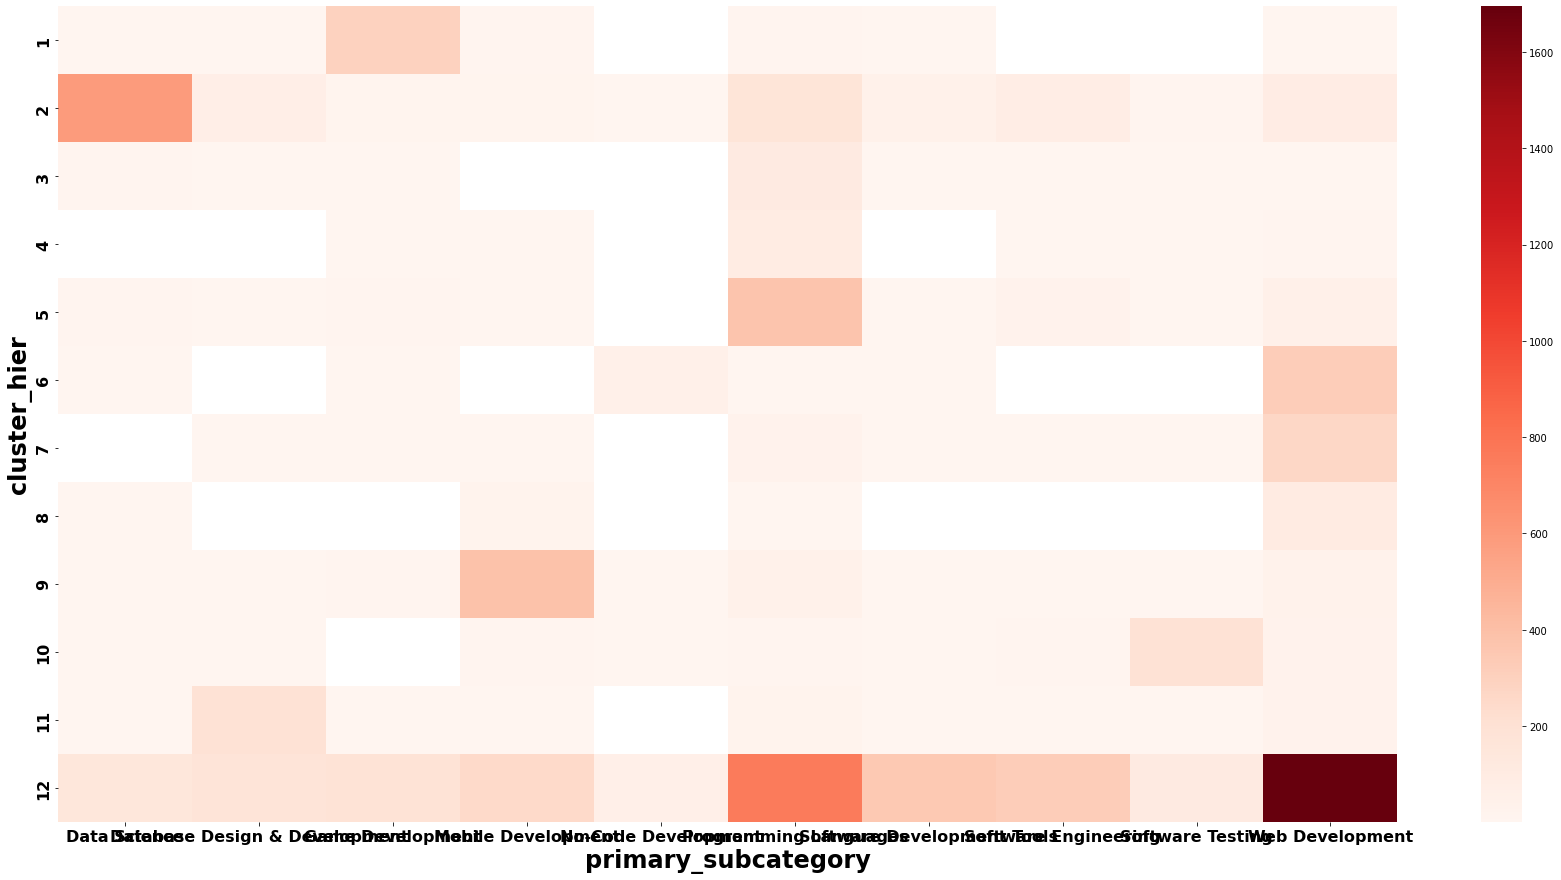

In [27]:
udemy_functions.heatmap_categories_cluster('cluster_hier', df_courses, 'Reds' )

The distribution of the clusters through hierarchical clustering is very unproportional.


### 4.2.4 PCA for plotting the courses

I will do a simple PCA analysis and keep the first 2 principal components int order to plot the courses in 2D. I will use the results ofthe kmeans clustering (with 6 groups), since the hierarchical clustering resulted in an overproportional group.

The explained variance through the first 2 principal comonent is 0.0317.


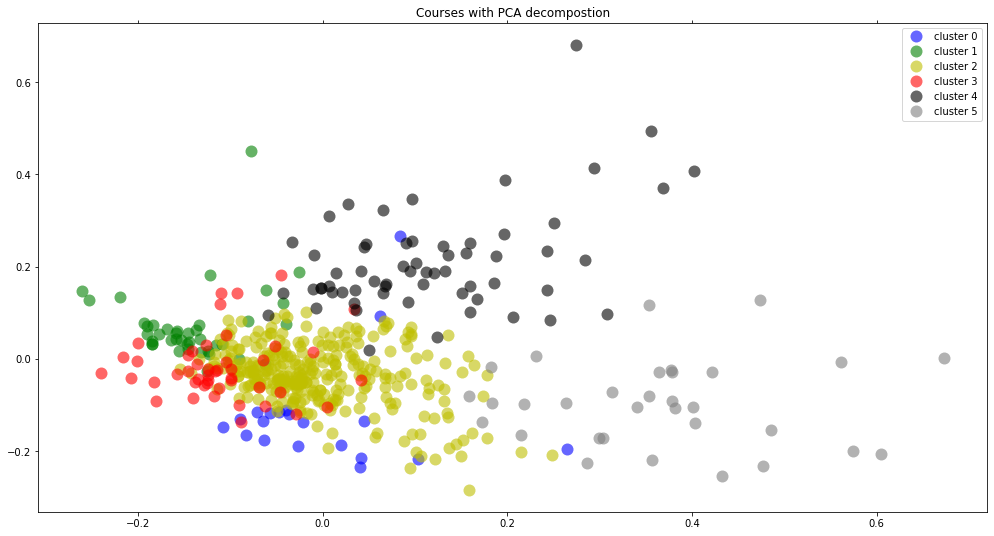

In [28]:
udemy_functions.plot_with_pca (X, df_courses['cluster'], 500)

In the 2-D plot, almost all the clusters are well separated from each other. Cluster0 and cluster5 overlap each other - in cluster 5 the majority of the courses can be found.

## 4.3. Clustering with the description

After building clusters with the objectives attribute, I investigated the course descriptions as the basis of the clustering algorithmns. I executed the same analyses and got better distributed clusters by means of the description feature.  

### 4.3.1. K-Means clustering - k=15 clusters

At first I tried to create 15 clusters, similar to the previous clusterings witht the attribute objective. There are clusters with only a few courses, so I tried to optimize the number of clusters to build (k). 

In [29]:
kmeans_descr = KMeans(n_clusters = 15, n_init = 10, random_state=1234)
kmeans_descr.fit(X_descr)

KMeans(n_clusters=15, random_state=1234)

In [30]:
#top 10 words in each cluster
common_words=udemy_functions.get_common_words(kmeans_descr, 10)
udemy_functions.print_common_words(common_words, word_features_descr, vocab_frame_descr)

0 : html, css, websites, web, bootstrap, development, design, create, use, page
1 : sql, database, data, server, query, mysql, tables, use, oracle, nbsp
2 : testing, automation, selenium, software, frameworks, use, nbsp, development, unit, api
3 : apps, android, ios, development, building, swift, flutter, use, coding, create
4 : javascript, web, use, coding, development, functions, languages, programming, interaction, building
5 : use, development, application, web, create, coding, building, project, php, get
6 : games, unity, create, development, 3d, use, making, 2d, engineer, coding
7 : wordpress, websites, theme, plugin, create, blog, site, nbsp, host, building
8 : python, programming, languages, data, use, coding, nbsp, basics, concepts, create
9 : react, application, building, use, redux, apps, components, js, native, web
10 : spring, angular, boot, application, use, frameworks, java, development, web, services
11 : nbsp, use, coding, development, programming, create, building, da

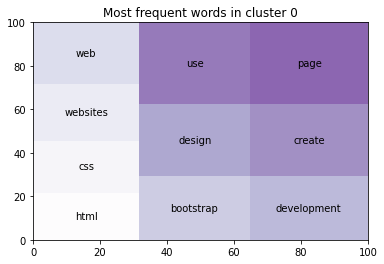

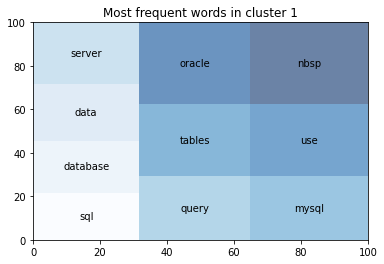

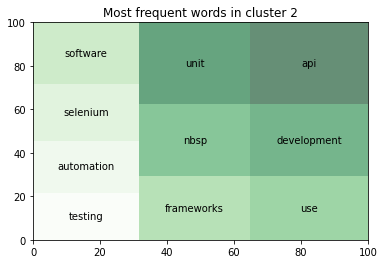

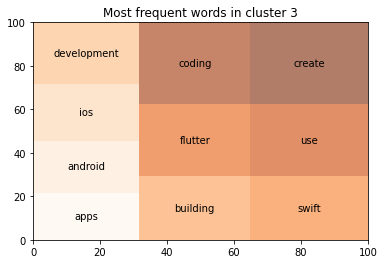

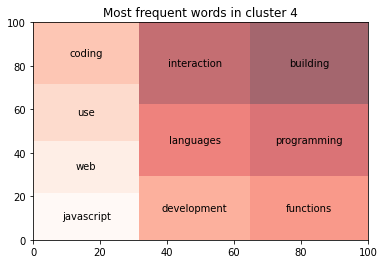

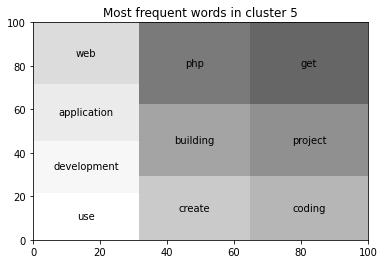

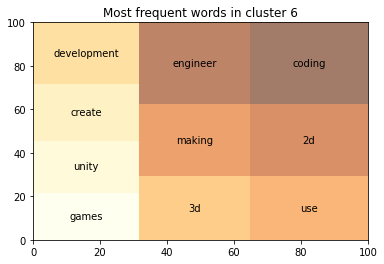

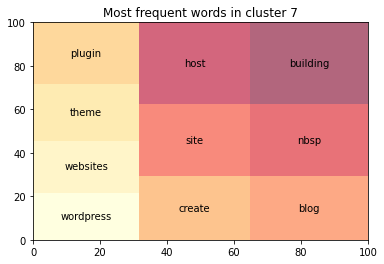

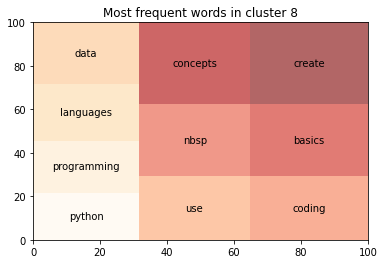

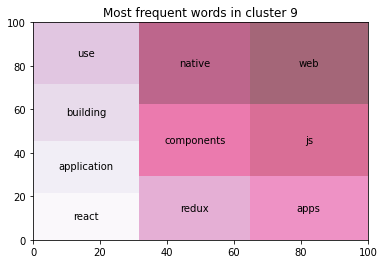

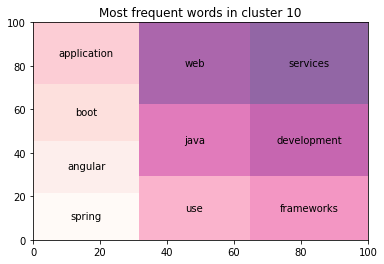

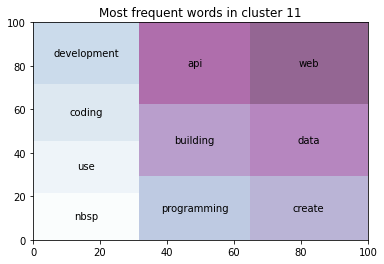

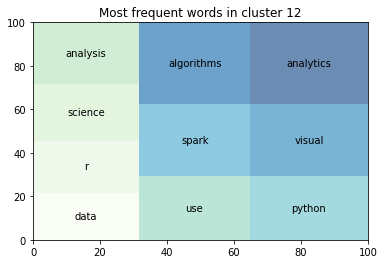

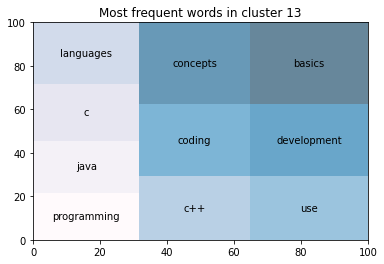

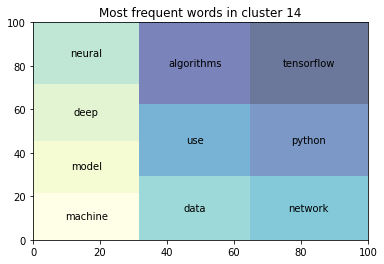

In [31]:
udemy_functions.squarify_words(common_words, word_features_descr, vocab_frame_descr)

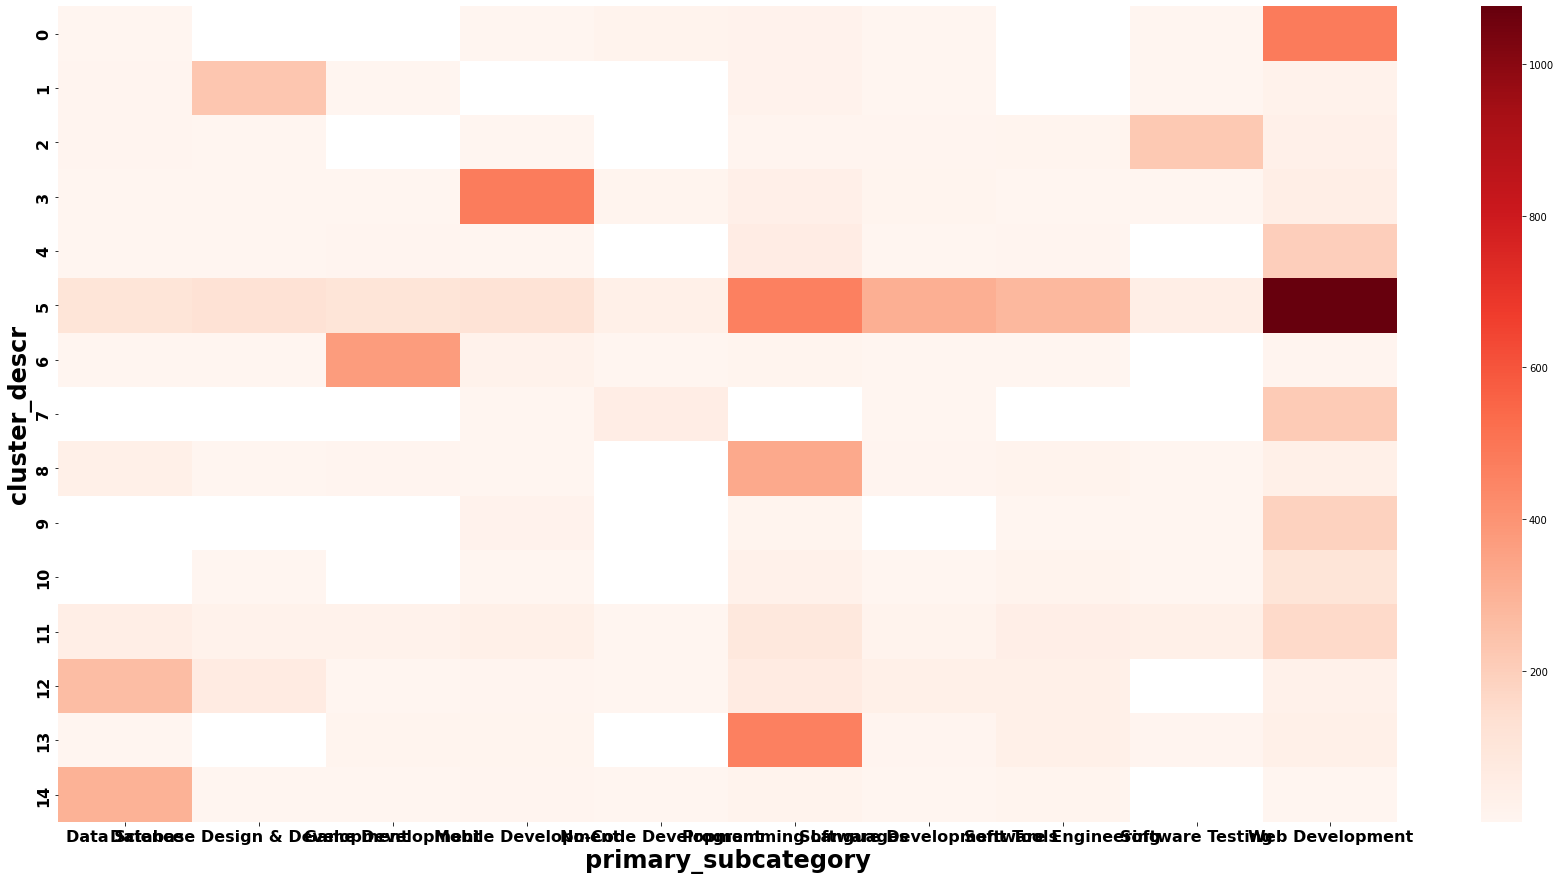

In [32]:
df_courses['cluster_descr']=kmeans_descr.labels_
udemy_functions.heatmap_categories_cluster('cluster_descr', df_courses, 'Reds')

In [33]:
#most of the courses are in cluster 4
df_courses['cluster_descr'].value_counts()

5     2679
3      607
13     577
0      524
12     510
11     478
8      440
6      427
14     349
2      291
1      286
4      279
7      268
9      222
10     165
Name: cluster_descr, dtype: int64

### 4.3.2 Relationship between number of clusters and inertia by the describtion attribute

In [34]:
kRange = range(1,30)
inertia_Kmean = udemy_functions.get_inertia(X_descr, kRange)

Text(9, 7800, "Let's try k=8")

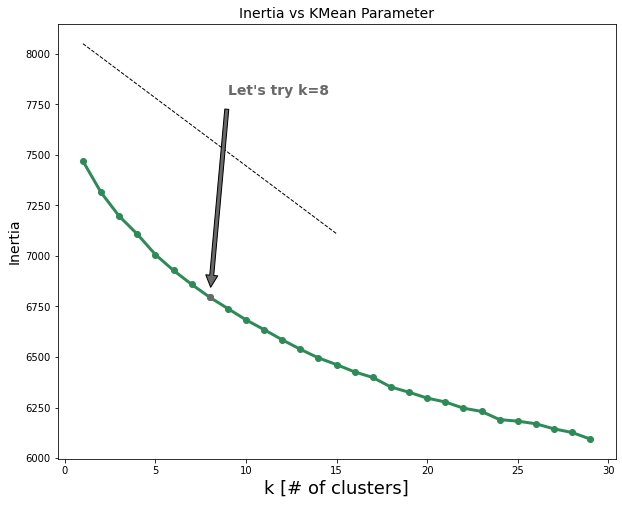

In [35]:
udemy_functions.plot_inertia(kRange, inertia_Kmean)
plt.plot([8], [inertia_Kmean[7]], 'o--', color='dimgray', linewidth=3)
plt.plot([1,8,15], [8050, 7580,7110], '--', color='k', linewidth=1)
plt.annotate("Let's try k=8", xy=(8, inertia_Kmean[7]), xytext=(9,7800),
             size=14, weight='bold', color='dimgray',
             arrowprops=dict(facecolor='dimgray', shrink=0.05))

### 4.3.3. K-Means with k=8 clusters

In [36]:
kmeans_descr = KMeans(n_clusters = 8, n_init = 10, random_state=123456)
kmeans_descr.fit(X_descr)

KMeans(random_state=123456)

In [37]:
#top 10 words in each cluster
common_words=udemy_functions.get_common_words(kmeans_descr, 10)
udemy_functions.print_common_words(common_words, word_features_descr, vocab_frame_descr)

0 : games, unity, create, development, 3d, use, making, 2d, coding, engineer
1 : nbsp, use, coding, programming, testing, create, development, building, data, api
2 : python, programming, languages, data, use, coding, nbsp, basics, development, create
3 : apps, android, react, ios, development, building, use, application, create, swift
4 : data, machine, science, use, r, algorithms, model, python, analysis, deep
5 : use, programming, development, application, web, testing, coding, javascript, java, create
6 : sql, database, data, server, query, mysql, tables, use, nbsp, oracle
7 : websites, wordpress, html, web, css, create, use, page, design, building


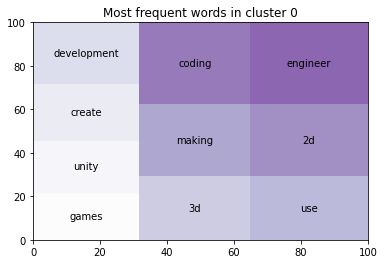

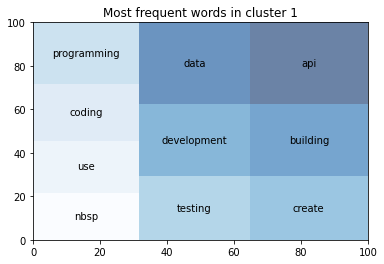

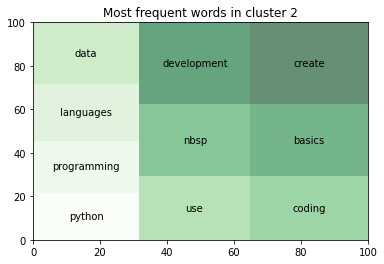

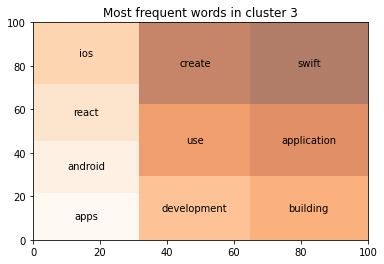

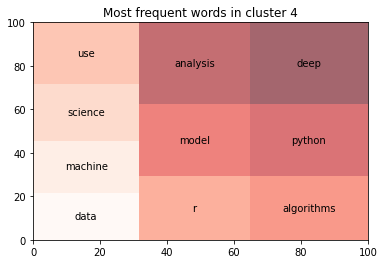

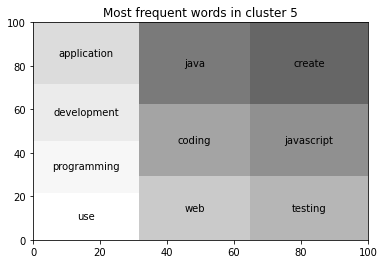

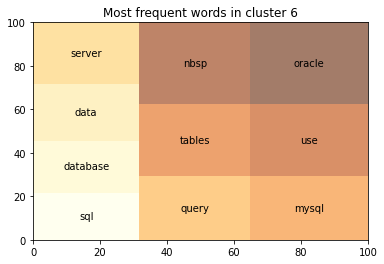

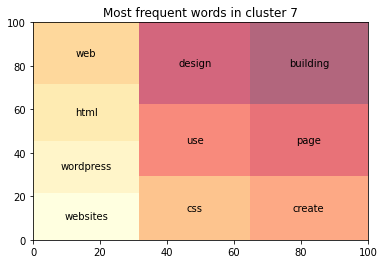

In [38]:
udemy_functions.squarify_words(common_words, word_features_descr, vocab_frame_descr)

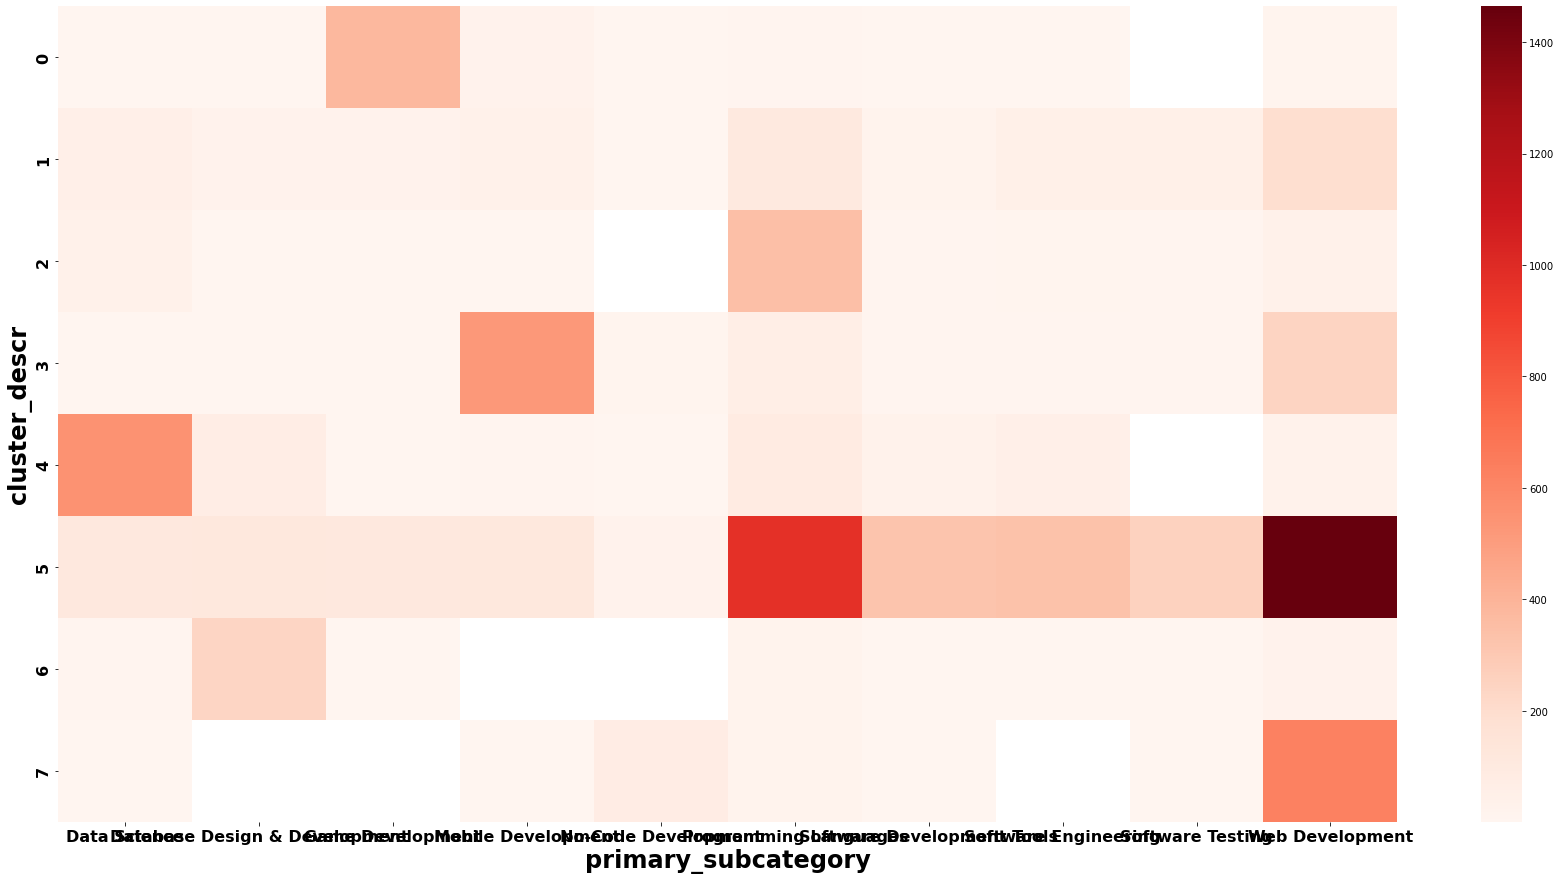

In [39]:
df_courses['cluster_descr']=kmeans_descr.labels_
udemy_functions.heatmap_categories_cluster('cluster_descr', df_courses, 'Reds')

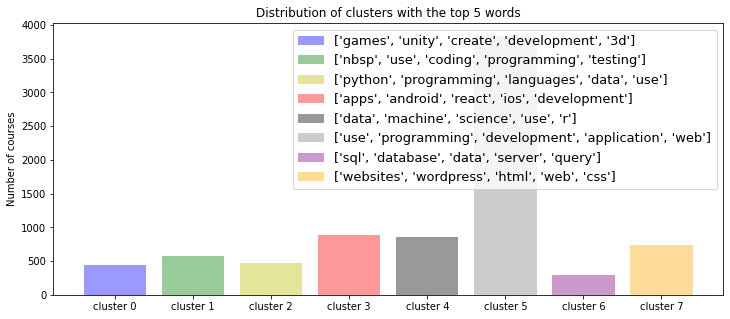

In [40]:
udemy_functions.plot_common_words(kmeans_descr, 5, word_features_descr, vocab_frame_descr, df_courses, 'cluster_descr')

In [41]:
udemy_functions.print_titles_cluster(3, df_courses, 'cluster_descr')

['web-design-secrets' 'code-dynamic-websites'
 'web-development-learn-by-doing-html5-css3-from-scratch-introductory']
['pythonforbeginnersintro' 'test-the-pyla-waters'
 'net-devops-cisco-python-automation-netconf-sdn-docker']
['java-tutorial' 'free-learn-c-tutorial-beginners' 'javascript-essentials']
['numpy-python' 'linear-regression-with-artificial-neural-network'
 'natural-language-processing-with-bert']
['git-and-github-crash-course-creating-a-repository-from-scratch'
 'foundations-of-front-end-development'
 'how-to-build-and-make-a-wordpress-website-from-scratch-2017']
['react-tutorial' 'learn-android-application-development-y'
 'become-an-android-developer-from-scratch']
['code-your-first-game' 'learnecs' 'ue5-steam']
['how-to-connect-java-jdbc-to-mysql' 'introduction-to-oracle-sql'
 'crudapp-using-nodejs-and-mongodbmern-project']


In [42]:
### 4.3.4. Hierarchical clustering

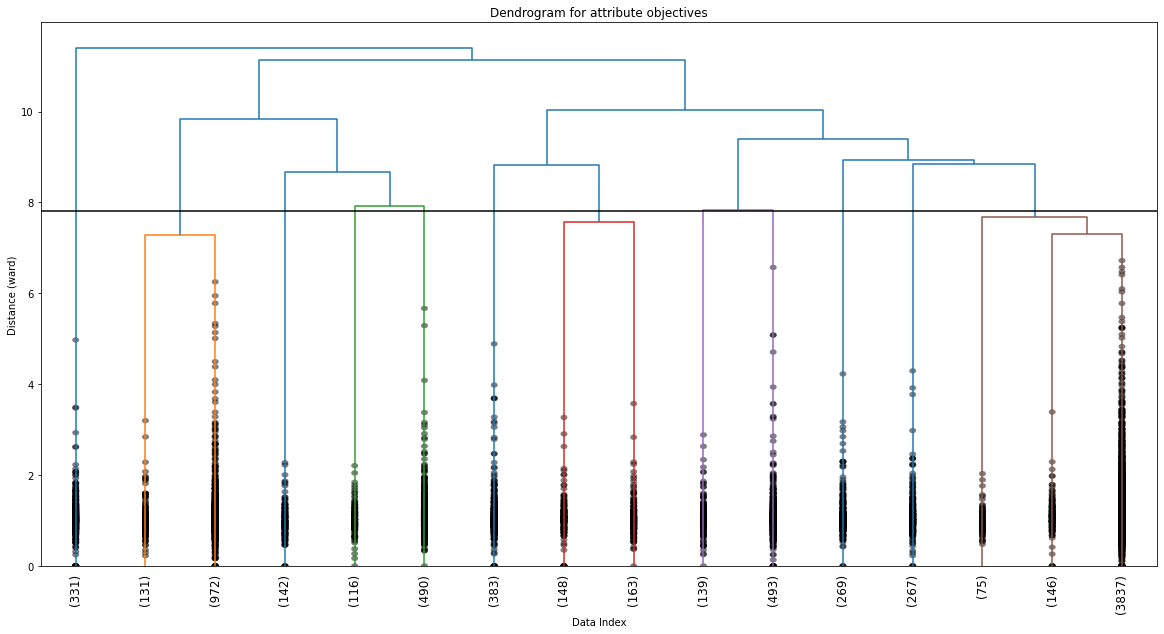

In [43]:
z_descr=udemy_functions.get_linkage(X_descr )
udemy_functions.plot_dendrogram(z, 16, line_dist=7.8)
#let's cut the dendrogrm at 7.8

In [44]:
#according to the dendrogram, I would cut the graph at 9.6
df_courses['cluster_hier_descr']=fcluster(Z=z_descr, t=9.6, criterion='distance')
df_courses['cluster_hier_descr'].value_counts()

9    3382
6     869
5     854
8     800
7     698
2     507
1     368
3     335
4     289
Name: cluster_hier_descr, dtype: int64

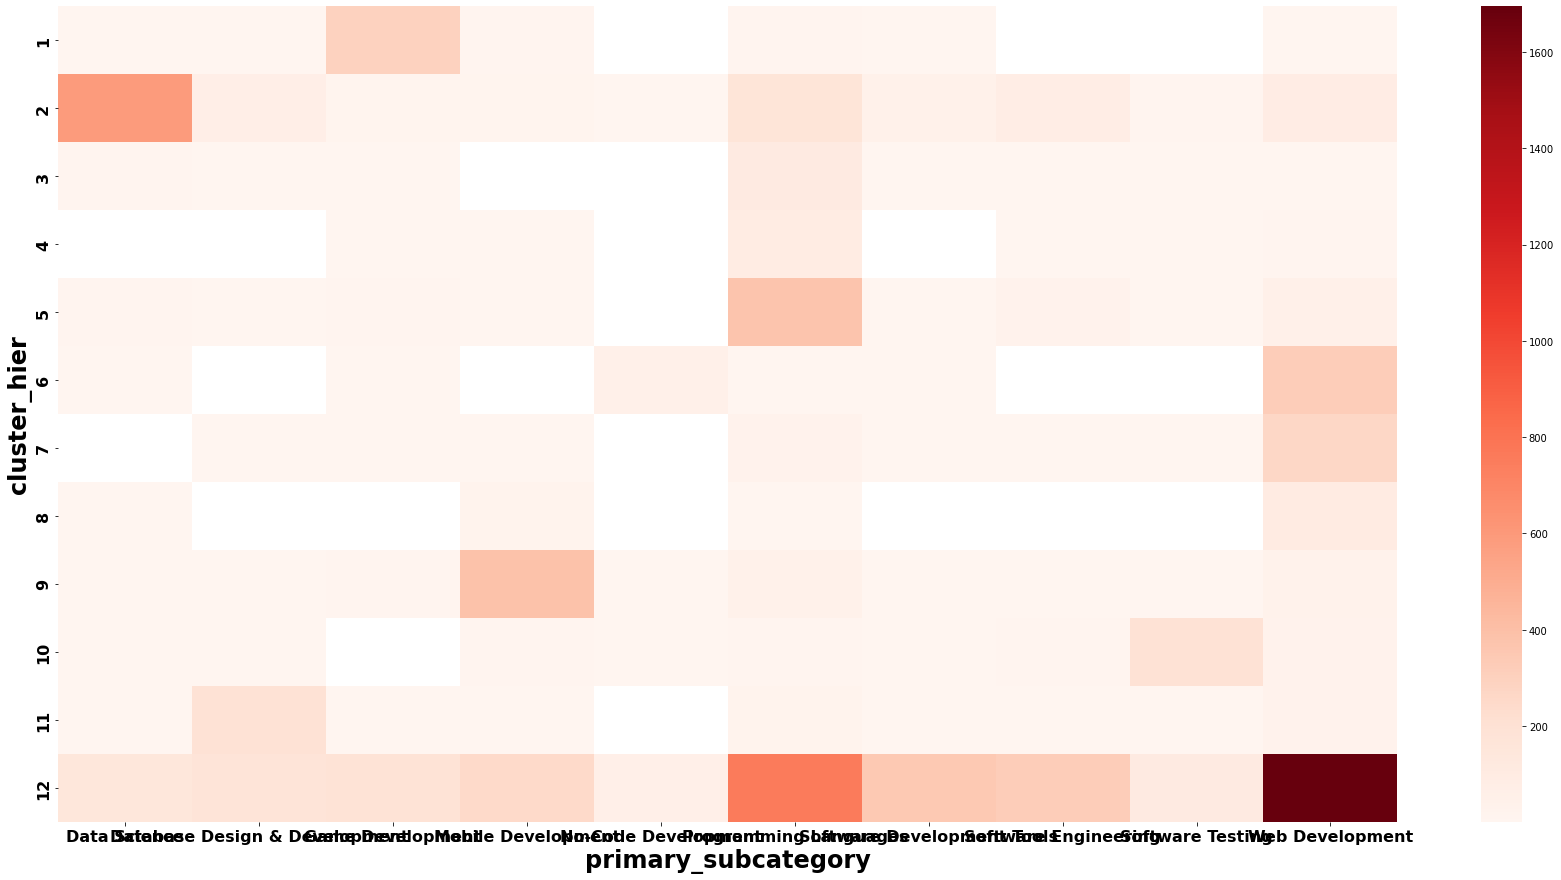

In [45]:
udemy_functions.heatmap_categories_cluster('cluster_hier', df_courses, 'Reds' )

The distribution of the clusters through hierarchical clustering is very unproportional with the attribute description as well. In the further analysis I will use results of the k-means clustering with k=8.

### 4.3.5. PCA

The explained variance through the first 2 principal comonent is 0.0502.


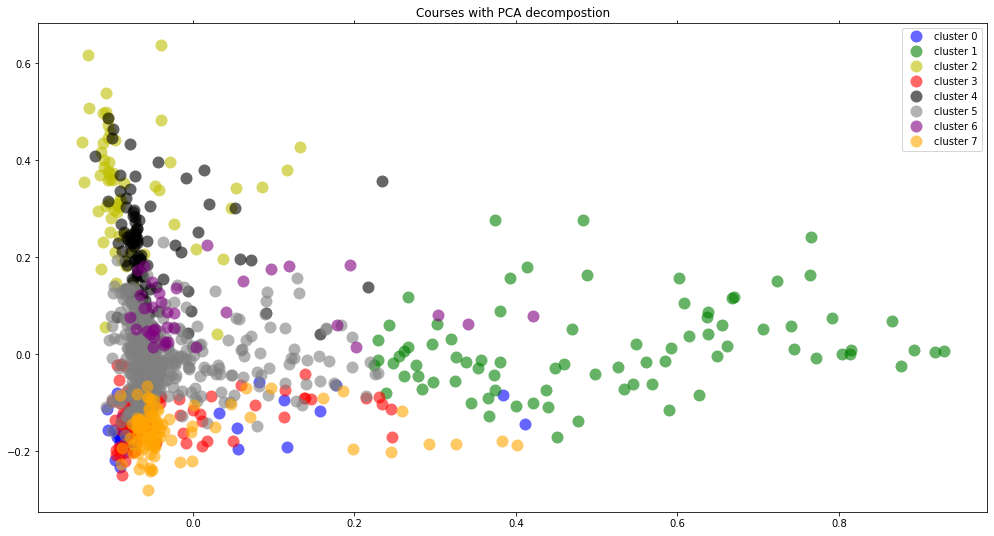

In [46]:
udemy_functions.plot_with_pca(X_descr, df_courses['cluster_descr'], 1000)

### 4.3.6. Export the clustering algorithm

In [47]:
filename ='kmeans8.sav'
pickle.dump(kmeans_descr, open(filename, 'wb'))

In [48]:
model_kmeans=pickle.load(open('kmeans8.sav', 'rb')) 
model_kmeans

KMeans(random_state=123456)

In [49]:
values=model_kmeans.predict(X_descr)

In [50]:
(values==df_courses['cluster_descr']).sum()

8102

There are clusters, which are close to each other, e.g. cluster 3 is between clusters 0 and 8. Clusters 7, 4 and 1 are also adjacent. It is important to remember that I kept only 2 pricipal components, that explain 4% of the total variance (which is plotted on the graph). In contrast, the clusters are not reduced, they contain all the informations.

## 4.4 Building the recommender system

For the recommender system I use the course features together with the result of the k-means clustering with k=8. 
I transformed the course dataset into a features matrix by keeping only the relevant features (e.g. no need for course id) For the categorical variables I introduced dummy variables. The clusters were also transformed into dummy variables, since the order of the clusters doesn't have any meaning (cluster 0 is not better or worse than cluster 1).
As the last step of the preparation I normalized the feature matrix, since the features have different scales. 
I used the cosine similarity to compare the courses which each other. 

There are 2 functions, which can be used to recommend courses:
 - Function recommend_for_user recommends courses for the user based on his/her previous courses. This function takes the user as input.
 - Function recommend_courses recommends courses based on another course_id. This function takes the course_id as input and looks for the courses that are similar to the original course.

### 4.4.1. Keeping the relevant features and prepare the dataframe

In [51]:
rel_cols=['avg_rating',  'has_certificate',  'instructional_level', 'num_lectures','num_quizzes',
          'num_practice_tests','is_practice_test_course', 'num_article_assets', 'num_curriculum_items',
          'num_subscribers','num_reviews',  'price', 'primary_subcategory','cluster_descr']
df_rel=df_courses[rel_cols]

In [52]:
df_rel['has_certificate']=df_rel['has_certificate'].astype(int)
df_rel['cluster_descr']=df_rel['cluster_descr'].astype(str)
dummies=pd.get_dummies(df_rel[['primary_subcategory', 'instructional_level','cluster_descr']], prefix=['subcat', 'level', 'cluster'])
df_rel.drop(columns=['primary_subcategory', 'instructional_level', 'cluster_descr'], inplace=True)
df_rel=pd.concat([df_rel,dummies], axis=1)
df_rel.head()

,avg_rating,has_certificate,num_lectures,num_quizzes,num_practice_tests,is_practice_test_course,num_article_assets,num_curriculum_items,num_subscribers,num_reviews,...,level_Expert Level,level_Intermediate Level,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,4.571429,0,20,2,0,False,7,22,520935,31052,...,0,0,0,0,0,0,0,0,0,1
1,4.496454,0,56,0,0,False,2,56,684240,58849,...,0,0,0,0,1,0,0,0,0,0
2,4.550599,0,74,0,0,False,4,74,1662635,94004,...,0,0,0,0,0,0,0,1,0,0
3,4.547253,0,82,0,0,False,2,82,547145,41287,...,0,0,0,0,0,0,0,1,0,0
4,4.540984,0,27,3,0,False,0,30,31950,1999,...,0,0,0,0,0,0,1,0,0,0


In [53]:
df_norm=udemy_functions.normalize_features(df_rel)

In [54]:
nr_user=df_reviews['user_name'].value_counts()
unique, counts = np.unique(nr_user, return_counts=True)
#dict(zip(unique, counts))
#recommend_for_user(user_name)

In [55]:
nr_user.sort_values()[:10]

Ilija Pavlovic                     1
Nghệ Kiến Diệp                     1
Sarang Sudhakar Rajpurohit         1
Sebastião amâncio                  1
Torben Borghoff                    1
Hotha N S V L SUVARNA AMARANADH    1
PRIYA RANJAN BEHERA                1
Lake maximilian                    1
Emad Kawas                         1
Ma. Estela G. Machi                1
Name: user_name, dtype: int64

In [56]:
udemy_functions.recommend_for_user('DEEPAK IYER', 5, df_reviews, df_courses, df_norm)

In [57]:
udemy_functions.recommend_for_user('Henk Bergsma', 5,df_reviews, df_courses, df_norm)

The following courses are recommended after taking the course microsoft-sql-from-a-to-z with the id 1005698:
                                     published_title  cosine_similarity
1  databases-with-python-mysql-sqlite-mongodb-wit...           0.940296
2                 gui-development-with-pyqt5-and-sql           0.931870
3             connection-strings-ms-access-adodb-dao           0.888617
4  python-pandas-connect-import-directly-any-data...           0.856200
5                learn-php-and-mysql-training-course           0.833028

